In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
sys.path.append('..')
from GIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import signal
from scipy.io.idl import readsav
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import requests
import ftplib
import io
import cmocean
from bs4 import BeautifulSoup
import urllib.request
from io import StringIO, BytesIO
from zipfile import ZipFile
import tqdm
import seaborn as sn
import re

## get SSP emissions
from tools.RCMIP import *

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
    
## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
# matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

%load_ext line_profiler
%load_ext memory_profiler

/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
../tools/RCMIP.py:61: PerformanceWarning: indexing past lexsort depth may impact performance.
  GIR_to_RCMIP_map.loc[RCMIP_to_GIR_map_concs.values(),'RCMIP_concs_unit'] = RCMIP_concs.loc[('World','ssp245')].reindex(RCMIP_to_GIR_map_concs.keys()).loc[:,'Unit'].values#.loc[('World','ssp245',RCMIP_to_GIR_map_concs.keys()),'Unit'].values


In [2]:
### import the required CMIP6 data:

onepct_data_corr = pd.read_csv('../tools/cmip6_data/onepct_tas_bias_corr.csv',index_col=0,header=[0,1])
abrupt_4x_data_corr = pd.read_csv('../tools/cmip6_data/abrupt4x_tas_N_bias_corr.csv',index_col=0,header=[0,1])
C4MIP_data_1 = pd.read_csv('../tmp/C4MIP_tas_CO2_flux.csv',index_col=0,header=[0,1,2])

for model in C4MIP_data_1.columns.levels[0]:
    for exp in ['1pctCO2'+x for x in ['','-bgc','-rad']]:
        burden = (C4MIP_data_1.loc[:,(model,exp,'CO2')] - C4MIP_data_1.loc[0,(model,exp,'CO2')]/1.01)/4.688876e-01
        emms = C4MIP_data_1.loc[:,(model,exp,'flux')].cumsum() + burden
        emms.loc[-1] = 0
        emms.sort_index(inplace=True)
        emms = emms.diff().loc[0:]
        burden_change = burden.copy()
        burden_change.loc[-1] = 0
        burden_change.sort_index(inplace=True)
        burden_change = burden_change.diff().loc[0:]
        C4MIP_data_1.loc[:,(model,exp,'burden')] = burden
        C4MIP_data_1.loc[:,(model,exp,'burden_change')] = burden_change
        C4MIP_data_1.loc[:,(model,exp,'emms')] = emms
        
C4MIP_data_1.sort_index(axis=1,inplace=True)

### Create the scenarios

idealised_test_concs = pd.DataFrame(284*1.01**(np.arange(200)),index=np.arange(200),columns=pd.MultiIndex.from_product([['1pctCO2'],['carbon_dioxide']]))
idealised_test_concs.loc[:,('abrupt_4xCO2','carbon_dioxide')] = 284*4

### Emission impulse scenario

idealised_test_emms = pd.DataFrame(0,index=np.arange(200),columns=pd.MultiIndex.from_product([['3TtC-impulse'],['carbon_dioxide']]))
idealised_test_emms.loc[0]=3000

In [3]:
## get constrained parameter ensembles:

def return_NROY_params(gas_param_file,response_param_file,level_constraint_file,rate_constrain_file):
    level_constraint = pd.read_pickle(level_constraint_file)
    rate_constraint = pd.read_pickle(rate_constrain_file)
    full_constraint = level_constraint & rate_constraint
    NROY_mems = full_constraint.index.levels[0][full_constraint]
    gas_params = pd.read_pickle(gas_param_file)#.reindex(NROY_mems,axis=1,level=0)
    response_params = pd.read_pickle(response_param_file)#.reindex(NROY_mems,axis=1,level=0)
    return gas_params,response_params,NROY_mems

In [4]:
param_set_start = 0
basedir = '../Parameter_Sets/NROY/'

gas_param_ensemble = []
thermal_param_ensemble = []
CONSTRAIN_all = []

for param_set_start in [0,10000,20000,30000,40000]:
    gas_params1, thermal_params1, CONSTRAIN = return_NROY_params(*[basedir+x+'_mem'+str(param_set_start)+'-mem'+str(param_set_start+9999)+'_v1.pkl' for x in ['gas_params','response_params','temp_constraint','rate_constraint']])
    gas_params1 = gas_params1.reindex(['carbon_dioxide'],axis=1,level=1)
    gas_param_ensemble+=[gas_params1]
    thermal_param_ensemble+=[thermal_params1]
    CONSTRAIN_all+=list(CONSTRAIN)
    
thermal_param_ensemble = pd.concat(thermal_param_ensemble,axis=1)
gas_param_ensemble = pd.concat(gas_param_ensemble,axis=1)

In [5]:
## run the idealised experiments:

gas_param_ensemble.loc['PI_conc'] = 284

idealised_test = run_GIR(concentrations_in=idealised_test_concs,gas_parameters=gas_param_ensemble,thermal_parameters=thermal_param_ensemble)
idealised_emms_test = run_GIR(emissions_in=idealised_test_emms,gas_parameters=gas_param_ensemble,thermal_parameters=thermal_param_ensemble)
gas_param_ensemble_bgc = gas_param_ensemble.copy()
gas_param_ensemble_bgc.loc['rT'] = 0 
idealised_test_bgc = run_GIR(concentrations_in=idealised_test_concs.reindex(['1pctCO2'],axis=1,level=0),gas_parameters=gas_param_ensemble_bgc,thermal_parameters=thermal_param_ensemble)

Integrating 2 scenarios, 50000 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 0 and 199...


100%|██████████| 199/199 [00:06<00:00, 31.16 timestep/s]


Integrating 1 scenarios, 50000 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 0 and 199...


100%|██████████| 199/199 [00:01<00:00, 142.73 timestep/s]


Integrating 1 scenarios, 50000 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 0 and 199...


100%|██████████| 199/199 [00:03<00:00, 53.73 timestep/s]


In [6]:
## computing the 5-95% for the TCRE plot:

TCRE_emms = idealised_test['Emissions']['1pctCO2'].cumsum().unstack().droplevel(1)
TCRE_T = idealised_test['T']['1pctCO2'].unstack()
TCRE_emms_constrain = idealised_test['Emissions']['1pctCO2'].reindex(CONSTRAIN_all,axis=1,level=0).cumsum().unstack().droplevel(1)
TCRE_T_constrain = idealised_test['T']['1pctCO2'].reindex(CONSTRAIN_all,axis=1).unstack()

emms_slices = np.arange(0,5051,50) # slices at which to take emissions

TCRE_5 = np.zeros(emms_slices.size-1)
TCRE_95 = np.zeros(emms_slices.size-1)
TCRE_50 = np.zeros(emms_slices.size-1)
TCRE_x = np.zeros(emms_slices.size-1)

TCRE_17_constrain = np.zeros(emms_slices.size-1)
TCRE_83_constrain = np.zeros(emms_slices.size-1)
TCRE_50_constrain = np.zeros(emms_slices.size-1)
TCRE_x_constrain = np.zeros(emms_slices.size-1)

for i in np.arange(TCRE_x.size):
    
    idx = (TCRE_emms>emms_slices[i])&(TCRE_emms<emms_slices[i+1])
    TCRE_x[i] = TCRE_emms.loc[idx].mean()
    TCRE_5[i] = TCRE_T.loc[idx].quantile(0.05)
    TCRE_50[i] = TCRE_T.loc[idx].quantile(0.5)
    TCRE_95[i] = TCRE_T.loc[idx].quantile(0.95)
    
    idx_constrain = (TCRE_emms_constrain>emms_slices[i])&(TCRE_emms_constrain<emms_slices[i+1])
    TCRE_x_constrain[i] = TCRE_emms_constrain.loc[idx_constrain].mean()
    TCRE_17_constrain[i] = TCRE_T_constrain.loc[idx_constrain].quantile(0.17)
    TCRE_50_constrain[i] = TCRE_T_constrain.loc[idx_constrain].quantile(0.5)
    TCRE_83_constrain[i] = TCRE_T_constrain.loc[idx_constrain].quantile(0.83)

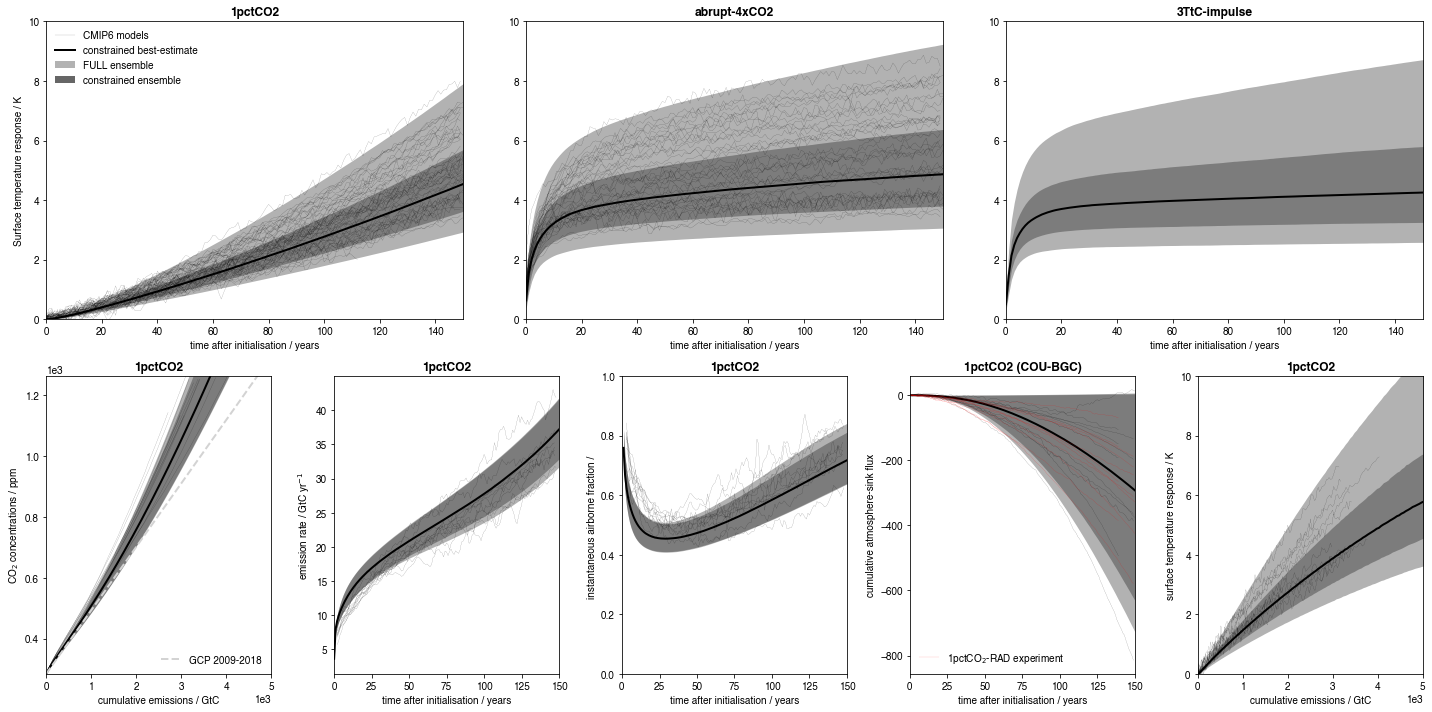

In [25]:
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(2, 15)
ax1 = [fig.add_subplot(gs[0,5*i:5*(i+1)]) for i in np.arange(3)]
ax2 = [fig.add_subplot(gs[1,3*i:3*(i+1)]) for i in np.arange(5)]

## 1pctCO2 response

ax1[0].fill_between(np.arange(200),*np.quantile(idealised_test['T']['1pctCO2'],[0.05,0.95],axis=1),alpha=0.3,color='k',lw=0)
ax1[0].fill_between(np.arange(200),*np.quantile(idealised_test['T']['1pctCO2'].reindex(CONSTRAIN_all,axis=1),[0.17,0.83],axis=1),alpha=0.3,color='k',lw=0)
ax1[0].plot(np.arange(200),np.quantile(idealised_test['T']['1pctCO2'].reindex(CONSTRAIN_all,axis=1),0.5,axis=1),color='k',lw=2)

onepct_data_corr.apply(pd.to_numeric).groupby(axis=1,level=0).mean().plot(ax=ax1[0],color='k',lw=0.1,legend=None)

## abrupt4x response

ax1[1].fill_between(np.arange(200),*np.quantile(idealised_test['T']['abrupt_4xCO2'],[0.05,0.95],axis=1),alpha=0.3,color='k',lw=0)
ax1[1].fill_between(np.arange(200),*np.quantile(idealised_test['T']['abrupt_4xCO2'].reindex(CONSTRAIN_all,axis=1),[0.17,0.83],axis=1),alpha=0.3,color='k',lw=0)
ax1[1].plot(np.arange(200),np.quantile(idealised_test['T']['abrupt_4xCO2'].reindex(CONSTRAIN_all,axis=1),0.5,axis=1),color='k',lw=2)

abrupt_4x_data_corr.xs('tas',axis=1,level=-1).plot(ax=ax1[1],color='k',lw=0.1,legend=None)

## abrupt2x response

ax1[2].fill_between(np.arange(200),*np.quantile(idealised_emms_test['T']['3TtC-impulse'],[0.05,0.95],axis=1),alpha=0.3,color='k',lw=0)
ax1[2].fill_between(np.arange(200),*np.quantile(idealised_emms_test['T']['3TtC-impulse'].reindex(CONSTRAIN_all,axis=1),[0.17,0.84],axis=1),alpha=0.3,color='k',lw=0)
ax1[2].plot(np.arange(200),np.quantile(idealised_emms_test['T']['3TtC-impulse'].reindex(CONSTRAIN_all,axis=1),0.5,axis=1),color='k',lw=2)

[a.set_xlim(0,150) for a in ax1]
[a.set_ylim(0,10) for a in ax1]
ax1[0].set_ylabel('Surface temperature response / K')
[a.set_xlabel('time after initialisation / years') for a in ax1]
[ax1[i].set_title(x,fontweight='bold') for i,x in enumerate(['1pctCO2','abrupt-4xCO2','3TtC-impulse'])]

## CC plots

## airborne fraction (GCP 2009-2018 = 0.445)

ax2[0].fill_betweenx(idealised_test['C']['1pctCO2']['carbon_dioxide'].loc[:150],*np.quantile(idealised_test['Emissions']['1pctCO2'].cumsum().loc[:150],[0.05,0.95],axis=1),alpha=0.3,color='k',lw=0)
ax2[0].fill_betweenx(idealised_test['C']['1pctCO2']['carbon_dioxide'].loc[:150],*np.quantile(idealised_test['Emissions']['1pctCO2'].reindex(CONSTRAIN_all,axis=1,level=0).cumsum().loc[:150],[0.05,0.95],axis=1),alpha=0.3,color='k',lw=0)
ax2[0].plot(np.quantile(idealised_test['Emissions']['1pctCO2'].reindex(CONSTRAIN_all,axis=1,level=0).cumsum().loc[:150],0.5,axis=1),idealised_test['C']['1pctCO2']['carbon_dioxide'].loc[:150],color='k',lw=2)

ax2[0].plot(C4MIP_data_1.xs('1pctCO2',axis=1,level=1).xs('emms',axis=1,level=1).cumsum(),C4MIP_data_1.xs('1pctCO2',axis=1,level=1).xs('CO2',axis=1,level=1),color='k',lw=0.1)

ax2[0].plot([0,5000],[284,284+5000*0.445*4.688876e-01],lw=2,ls='--',color='lightgrey')

ax2[0].set_ylim(284,284*1.01**150)
ax2[0].set_xlim(0,5000)

## emission rate

ax2[1].fill_between(np.arange(151),*np.quantile(idealised_test['Emissions']['1pctCO2'].loc[:150],[0.05,0.95],axis=1),alpha=0.3,color='k',lw=0)
ax2[1].fill_between(np.arange(151),*np.quantile(idealised_test['Emissions']['1pctCO2'].reindex(CONSTRAIN_all,axis=1,level=0).loc[:150],[0.05,0.95],axis=1),alpha=0.3,color='k',lw=0)
ax2[1].plot(np.arange(151),np.quantile(idealised_test['Emissions']['1pctCO2'].reindex(CONSTRAIN_all,axis=1,level=0).loc[:150],0.5,axis=1),color='k',lw=2)

ax2[1].plot(C4MIP_data_1.xs('1pctCO2',axis=1,level=1).xs('emms',axis=1,level=1).rolling(5,center=True).mean(),color='k',lw=0.1)

## airborne fraction

ax2[2].fill_between(np.arange(151),*np.quantile(idealised_test['C']['1pctCO2'].loc[:150].diff().values/4.688876e-01/idealised_test['Emissions']['1pctCO2'].loc[:150],[0.05,0.95],axis=1),lw=0,alpha=0.3,color='k')
ax2[2].fill_between(np.arange(151),*np.quantile(idealised_test['C']['1pctCO2'].loc[:150].diff().values/4.688876e-01/idealised_test['Emissions']['1pctCO2'].reindex(CONSTRAIN_all,axis=1,level=0).loc[:150],[0.05,0.95],axis=1),lw=0,alpha=0.3,color='k')
ax2[2].plot(np.arange(151),np.quantile(idealised_test['C']['1pctCO2'].loc[:150].diff().values/4.688876e-01/idealised_test['Emissions']['1pctCO2'].reindex(CONSTRAIN_all,axis=1,level=0).loc[:150],0.5,axis=1),color='k',lw=2)

ax2[2].plot(C4MIP_data_1.xs('1pctCO2',axis=1,level=1).xs('CO2',axis=1,level=1).diff().rolling(5,center=True).mean()/4.688876e-01/C4MIP_data_1.xs('1pctCO2',axis=1,level=1).xs('emms',axis=1,level=1).rolling(5,center=True).mean(),color='k',lw=0.1)
# ax2[2].plot((C4MIP_data_1.xs('1pctCO2',axis=1,level=1).xs('CO2',axis=1,level=1)-C4MIP_data_1.xs('1pctCO2',axis=1,level=1).xs('CO2',axis=1,level=1).iloc[0]/1.01)/4.688876e-01/C4MIP_data_1.xs('1pctCO2',axis=1,level=1).xs('emms',axis=1,level=1).cumsum(),color='k',lw=0.1)

ax2[2].set_ylim(0,1)

## effective RAD flux

ax2[3].fill_between(np.arange(151),*np.quantile((idealised_test['Emissions']['1pctCO2']-idealised_test_bgc['Emissions']['1pctCO2']).loc[:150].cumsum(),[0.05,0.95],axis=1),lw=0,alpha=0.3,color='k')
ax2[3].fill_between(np.arange(151),*np.quantile((idealised_test['Emissions']['1pctCO2']-idealised_test_bgc['Emissions']['1pctCO2']).reindex(CONSTRAIN_all,axis=1,level=0).loc[:150].cumsum(),[0.05,0.95],axis=1),lw=0,alpha=0.3,color='k')
ax2[3].plot(np.arange(151),np.quantile((idealised_test['Emissions']['1pctCO2']-idealised_test_bgc['Emissions']['1pctCO2']).reindex(CONSTRAIN_all,axis=1,level=0).loc[:150].cumsum(),0.5,axis=1),color='k',lw=2)

ax2[3].plot(C4MIP_data_1.xs('1pctCO2',axis=1,level=1).xs('flux',axis=1,level=1).cumsum()-C4MIP_data_1.xs('1pctCO2-bgc',axis=1,level=1).xs('flux',axis=1,level=1).cumsum(),color='k',lw=0.1)
ax2[3].plot(C4MIP_data_1.xs('1pctCO2-rad',axis=1,level=1).xs('flux',axis=1,level=1).cumsum(),color='red',lw=0.1)

## TCRE

ax2[4].fill_between(TCRE_x,TCRE_5,TCRE_95,alpha=0.3,color='k',lw=0)
ax2[4].fill_between(TCRE_x_constrain,TCRE_17_constrain,TCRE_83_constrain,alpha=0.3,color='k',lw=0)
ax2[4].plot(TCRE_x_constrain,TCRE_50_constrain,color='k',lw=2)

ax2[4].plot(C4MIP_data_1.xs('1pctCO2',axis=1,level=1).xs('emms',axis=1,level=1).cumsum(),C4MIP_data_1.xs('1pctCO2',axis=1,level=1).xs('tas',axis=1,level=1),color='k',lw=0.1)

ax2[4].set_xlim(0,5000)
ax2[4].set_ylim(0,10)

# labels etc

[ax2[i].set_ylabel(x) for i,x in enumerate(['CO$_2$ concentrations / ppm','emission rate / GtC yr$^{-1}$','instantaneous airborne fraction / ','cumulative atmosphere-sink flux','surface temperature response / K'])]
[ax2[i].set_xlabel(x) for i,x in enumerate(['cumulative emissions / GtC','time after initialisation / years','time after initialisation / years','time after initialisation / years','cumulative emissions / GtC'])]
[ax2[i].set_title(x,fontweight='bold') for i,x in enumerate(['1pctCO2','1pctCO2','1pctCO2','1pctCO2 (COU-BGC)','1pctCO2'])]

[a.set_xlim(0,150) for a in ax2[1:-1]]

ax1[0].plot([],[],color='k',lw=0.1,label='CMIP6 models')
ax1[0].fill_between([],[],color='k',lw=0,alpha=0.3,label='FULL ensemble')
ax1[0].fill_between([],[],color='k',lw=0,alpha=0.6,label='constrained ensemble')
ax1[0].plot([],[],color='k',lw=2,label='constrained best-estimate')

ax2[0].plot([],[],lw=2,ls='--',color='lightgrey',label='GCP 2009-2018')

ax2[3].plot([],[],color='red',lw=0.1,label='1pctCO$_2$-RAD experiment')

plt.tight_layout()

ax1[0].legend(loc='upper left',handles = ax1[0].get_legend_handles_labels()[0][-4:],labels = ax1[0].get_legend_handles_labels()[1][-4:])
ax2[0].legend(loc='lower right')
ax2[3].legend(loc='lower left')

# fig.patch.set_facecolor('white')

In [26]:
[fig.savefig('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/Plots/Idealised_exp_constrained.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf','svg']]

[None, None, None]